Cylinder Flow (Steady) DEMO code

This notebook demonstrates solving steady-state Cavity Flow with the same setup as https://www.comsol.com/blogs/how-to-solve-a-classic-cfd-benchmark-the-lid-driven-cavity-problem.

In [1]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [2]:
rectangle = df.geometry.rectangle([0, 1], [0, 1])
point = df.geometry.point(0,0)

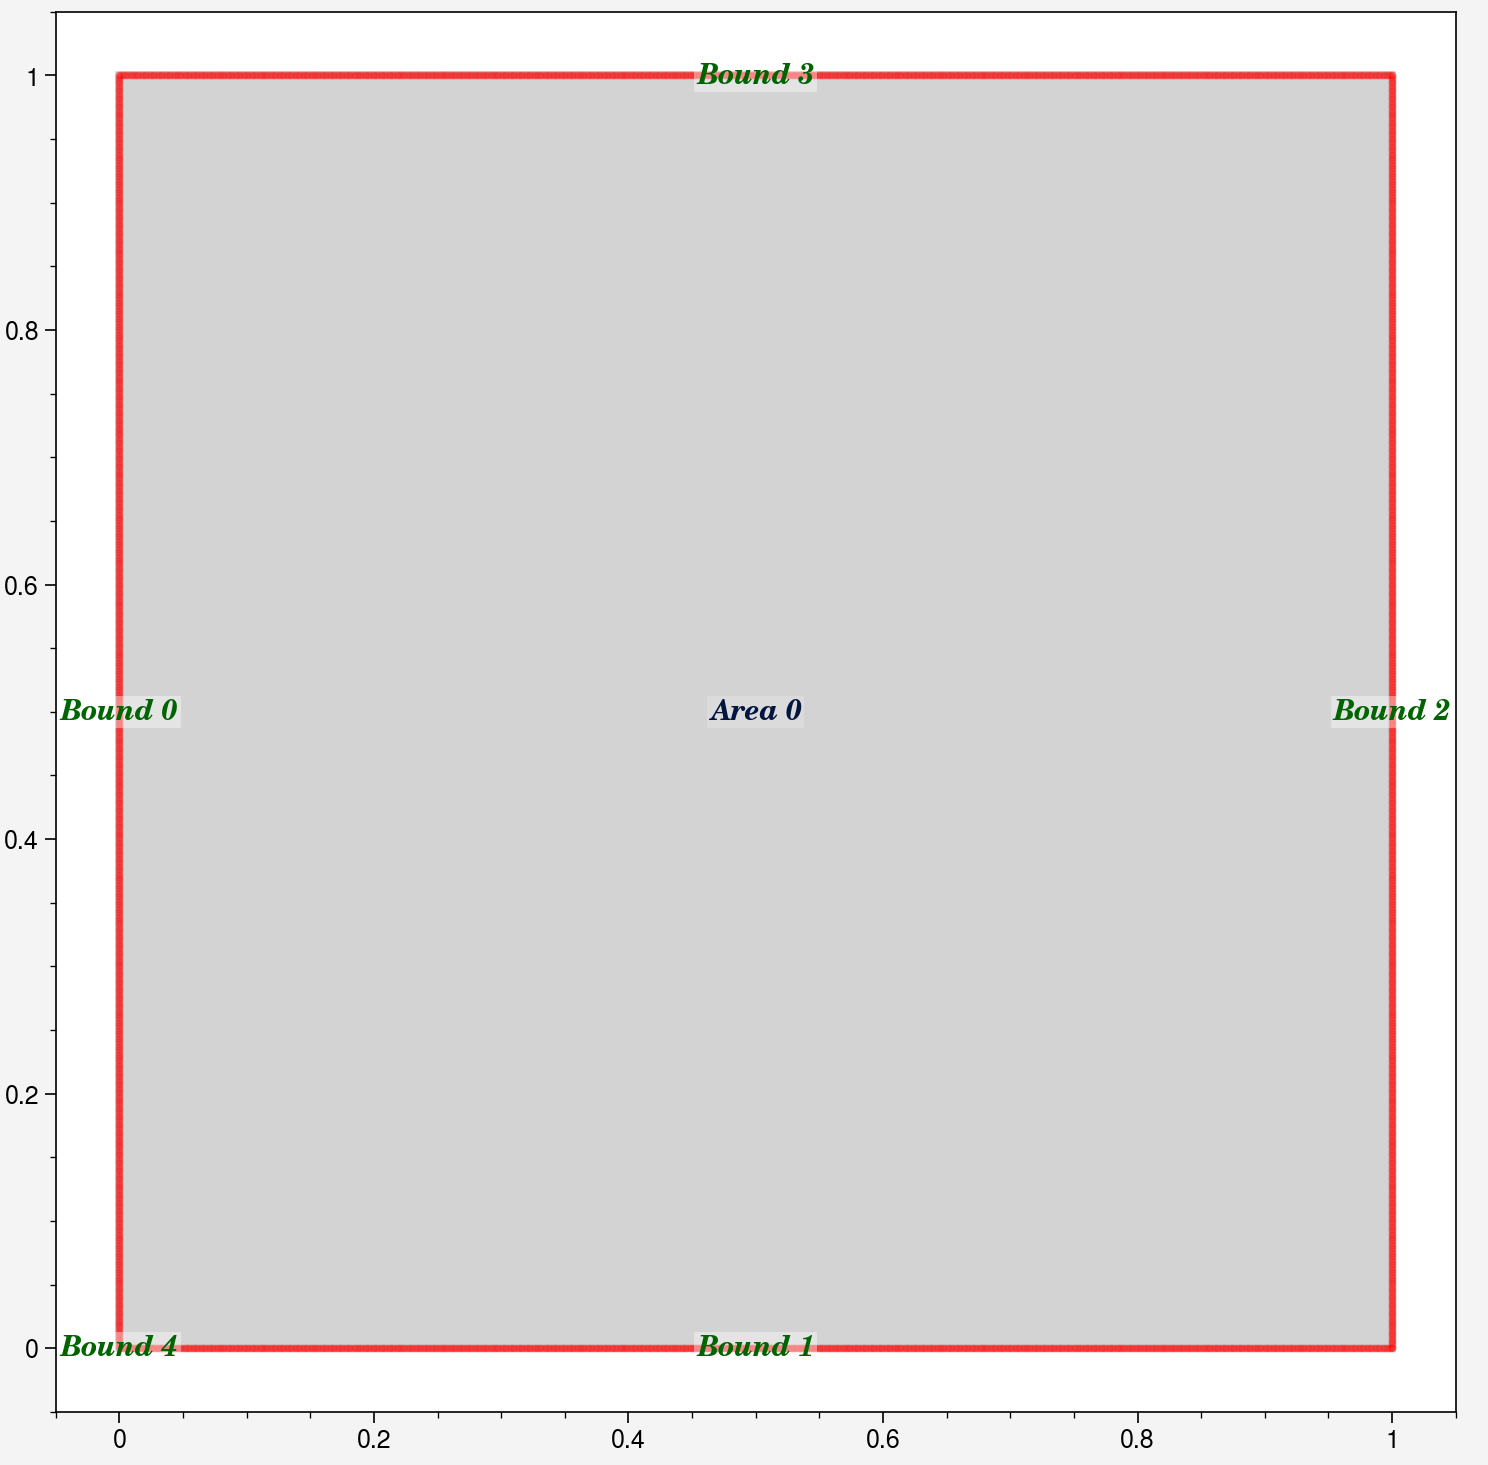

In [3]:
domain = df.domain(rectangle, point)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

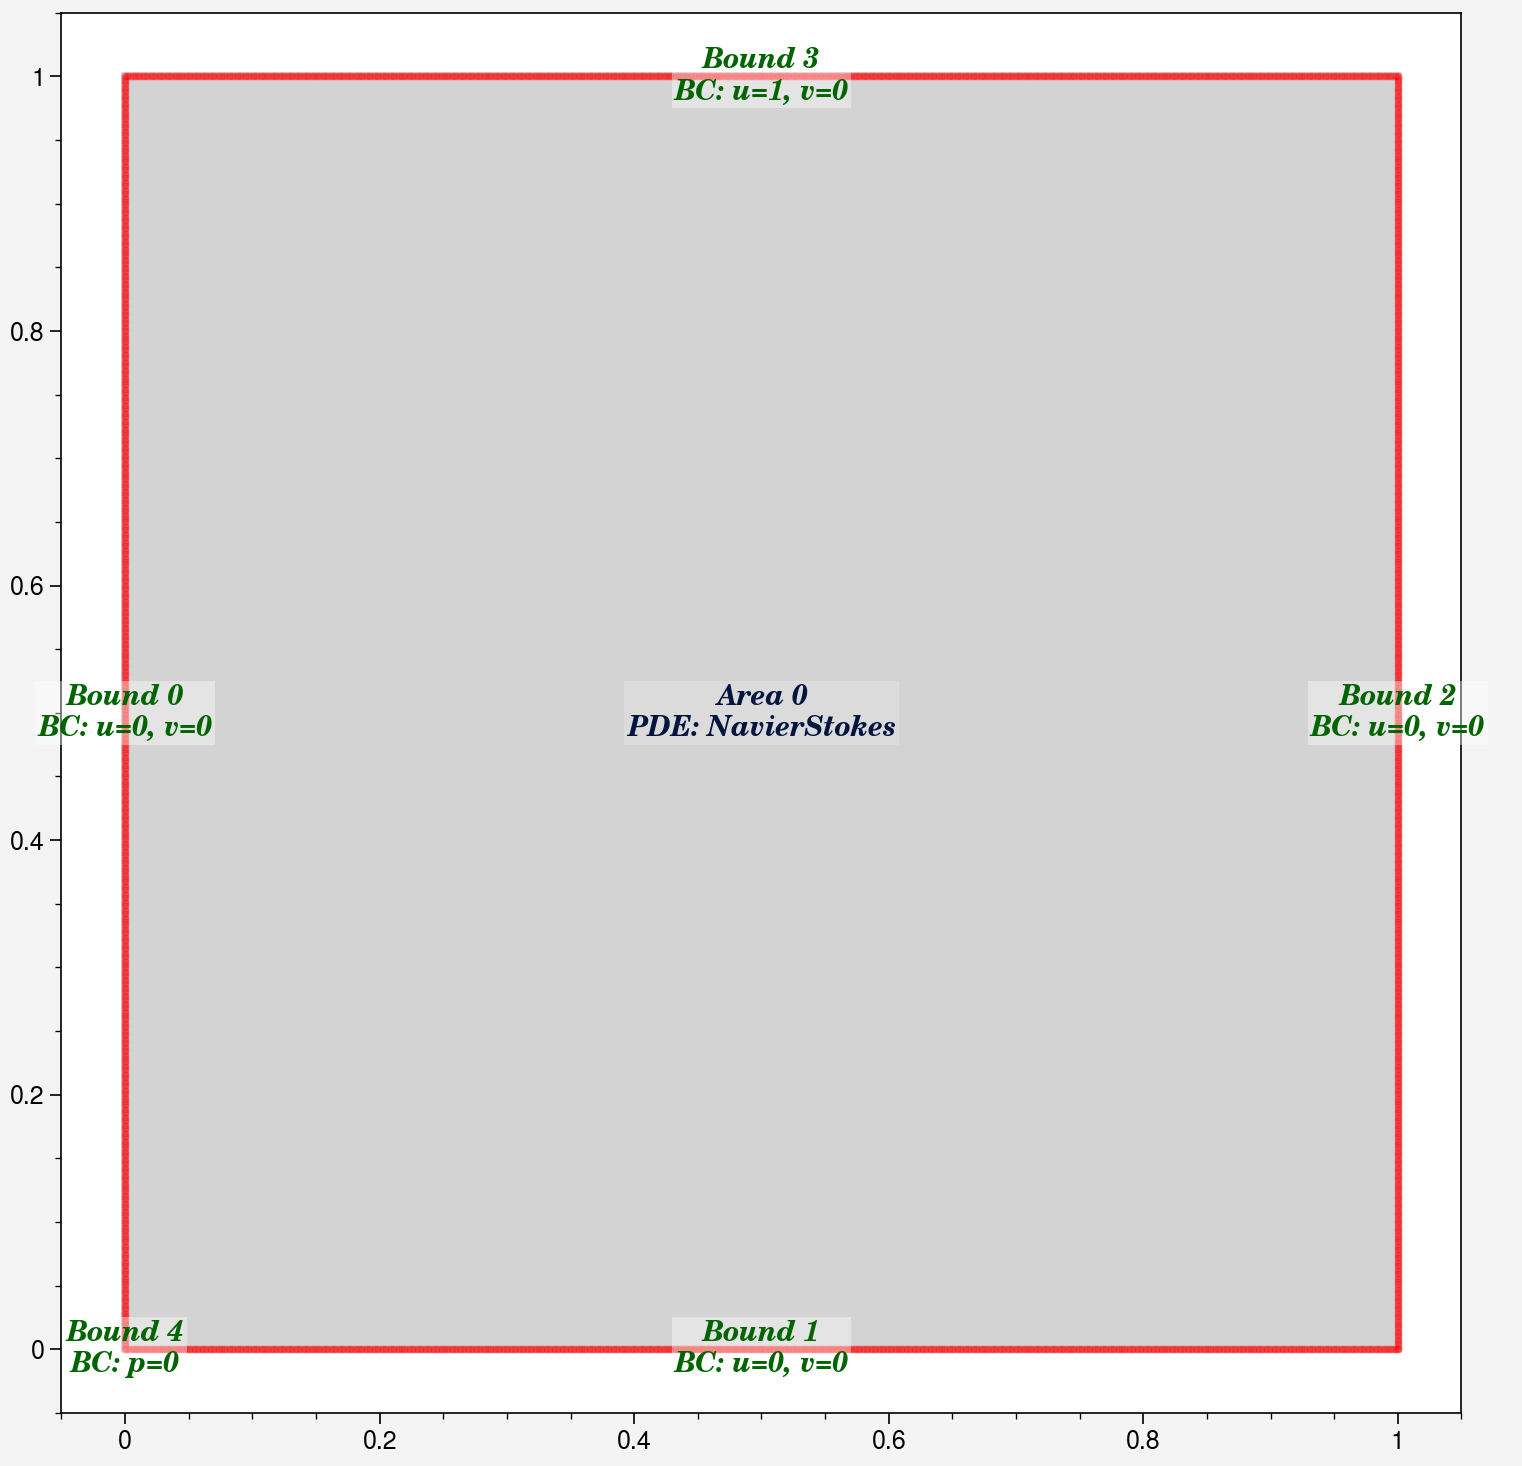

In [4]:
domain.bound_list[0].define_bc({'u': 0,'v': 0})
domain.bound_list[1].define_bc({'u': 0,'v': 0})
domain.bound_list[2].define_bc({'u': 0,'v': 0})
domain.bound_list[3].define_bc({'u': 1, 'v': 0})
domain.bound_list[4].define_bc({'p': 0})
domain.area_list[0].define_pde(df.NavierStokes(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training.

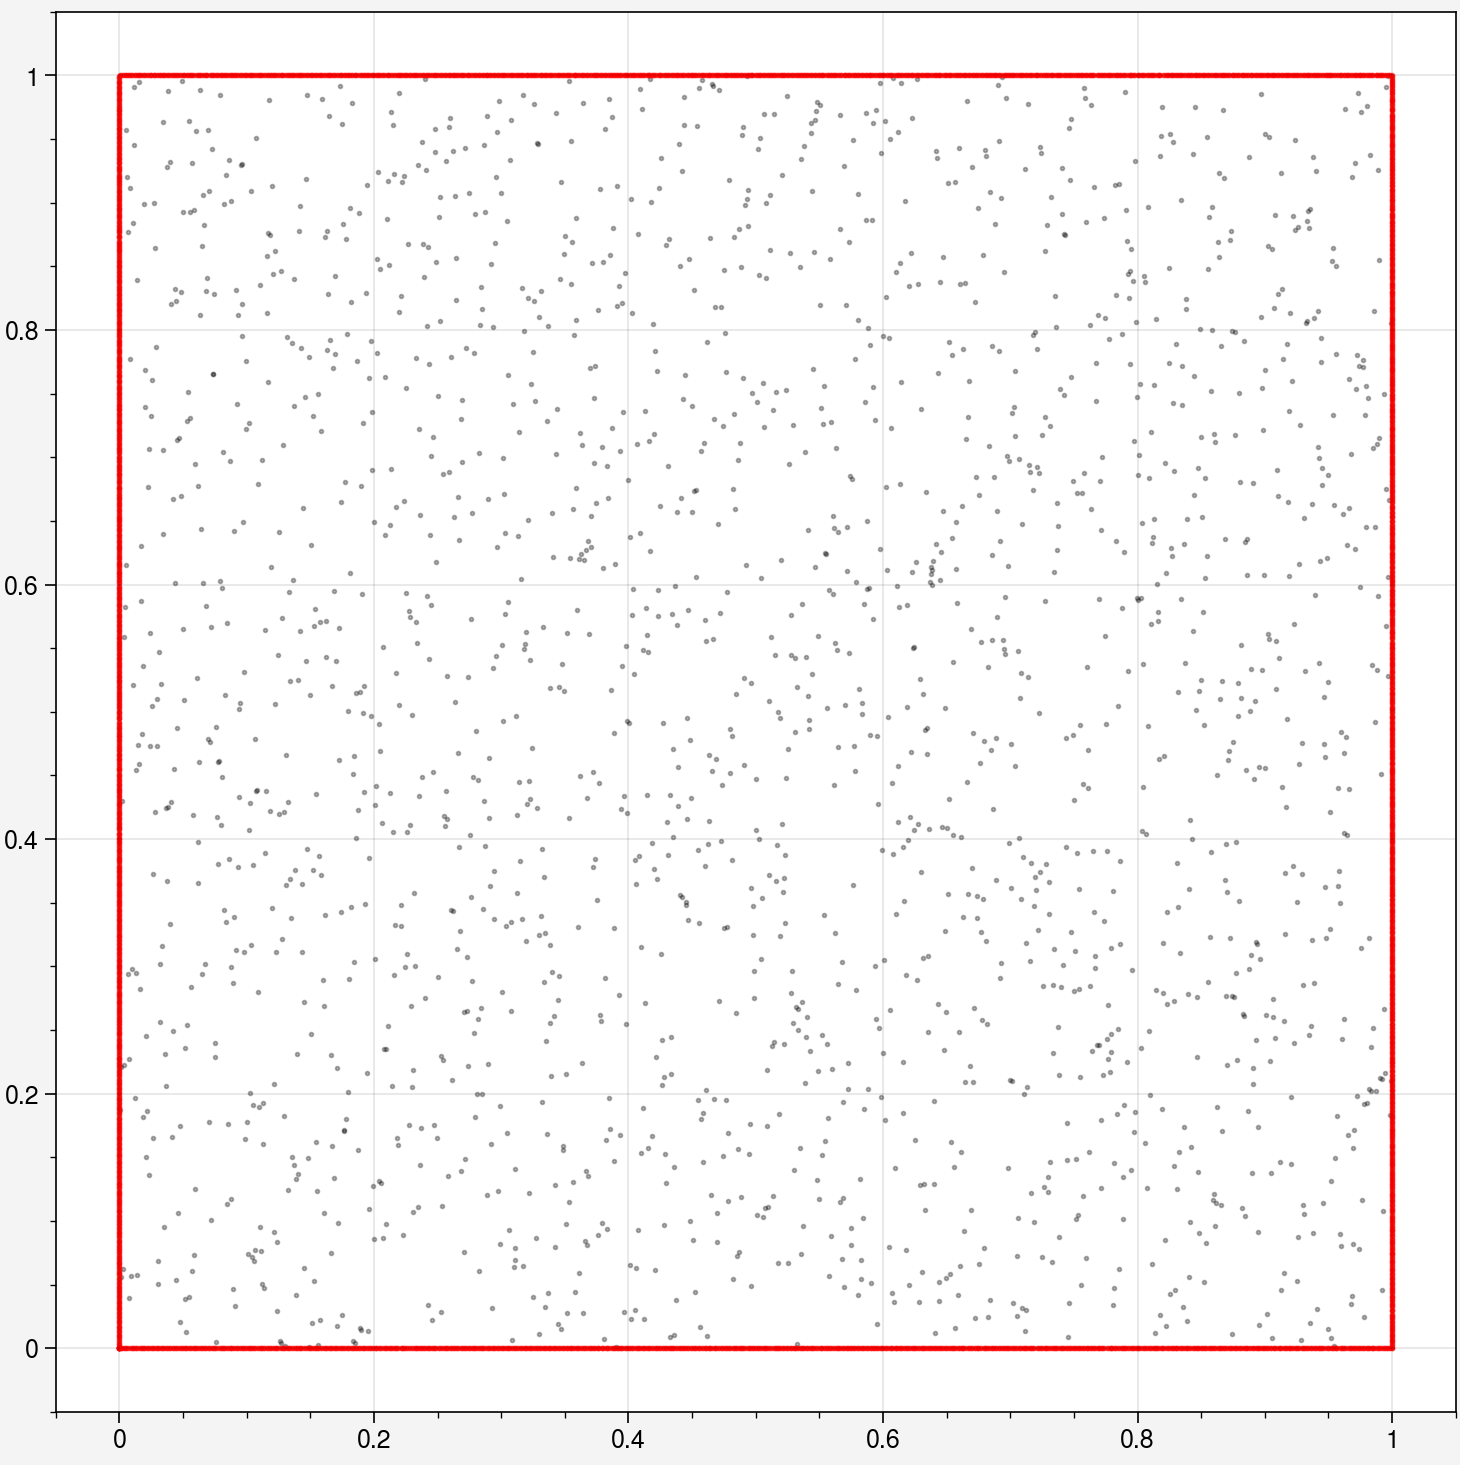

In [5]:
domain.sampling_lhs(bound_sampling_res=[1000, 1000, 1000, 1000, 10], area_sampling_res=[2000])
domain.show_coordinates(display_physics=False)

## 3. Train the PINN model

Define how collocation points are sampled during training.

In [6]:
def do_in_adam(epoch, model):
    return
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[1000, 1000, 1000, 1000], area_sampling_res=[2000])
        print(domain)
        
def do_in_lbfgs(epoch, model):
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[1000, 1000, 1000, 1000], area_sampling_res=[2000])
        print(domain)

Train the model using Adam for initial training (faster convergence).

In [7]:
model0 = df.PINN(width=50, length=5, input_vars=['x','y'], output_vars=['u','v','p'])

# Train the model
model1, model1best = model0.train_adam(
    learning_rate=0.004,
    epochs=2000,
    calc_loss=df.calc_loss_simple(domain),
    threshold_loss=0.005,
    do_between_epochs=do_in_adam)

Epoch: 1, total_loss: 1.25131, bc_loss: 1.25079, pde_loss: 0.00053
Epoch: 200, total_loss: 0.07023, bc_loss: 0.06000, pde_loss: 0.01023
Epoch: 400, total_loss: 0.06334, bc_loss: 0.05648, pde_loss: 0.00687
Epoch: 600, total_loss: 0.05313, bc_loss: 0.04597, pde_loss: 0.00716
Epoch: 800, total_loss: 0.05231, bc_loss: 0.04092, pde_loss: 0.01139
Epoch: 1000, total_loss: 0.04184, bc_loss: 0.03366, pde_loss: 0.00818
Epoch: 1200, total_loss: 0.03640, bc_loss: 0.02686, pde_loss: 0.00954
Epoch: 1400, total_loss: 0.02922, bc_loss: 0.02091, pde_loss: 0.00831
Epoch: 1600, total_loss: 0.02525, bc_loss: 0.01836, pde_loss: 0.00689
Epoch: 1800, total_loss: 0.07843, bc_loss: 0.05686, pde_loss: 0.02157
Epoch: 2000, total_loss: 0.02943, bc_loss: 0.02339, pde_loss: 0.00604


Refine the model using LBFGS for higher precision.

In [8]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=df.calc_loss_simple(domain),
    epochs=350,
    threshold_loss=0.0001,
    do_between_epochs=do_in_lbfgs)

Epoch: 1878, total_loss: 0.01468, bc_loss: 0.01227, pde_loss: 0.00241
Epoch: 1928, total_loss: 0.00323, bc_loss: 0.00235, pde_loss: 0.00088
Epoch: 1978, total_loss: 0.00238, bc_loss: 0.00167, pde_loss: 0.00071
number of bound : ['0: 1343', '1: 1472', '2: 1194', '3: 1184', '4: 10']
number of area : ['0: 2714']
Epoch: 2028, total_loss: 0.00342, bc_loss: 0.00230, pde_loss: 0.00112
Epoch: 2078, total_loss: 0.00237, bc_loss: 0.00178, pde_loss: 0.00059
number of bound : ['0: 1634', '1: 2014', '2: 1499', '3: 1399', '4: 10']
number of area : ['0: 3414']
Epoch: 2128, total_loss: 0.00085, bc_loss: 0.00057, pde_loss: 0.00028
Epoch: 2178, total_loss: 0.00030, bc_loss: 0.00015, pde_loss: 0.00014
number of bound : ['0: 1968', '1: 2552', '2: 1707', '3: 1788', '4: 10']
number of area : ['0: 4179']


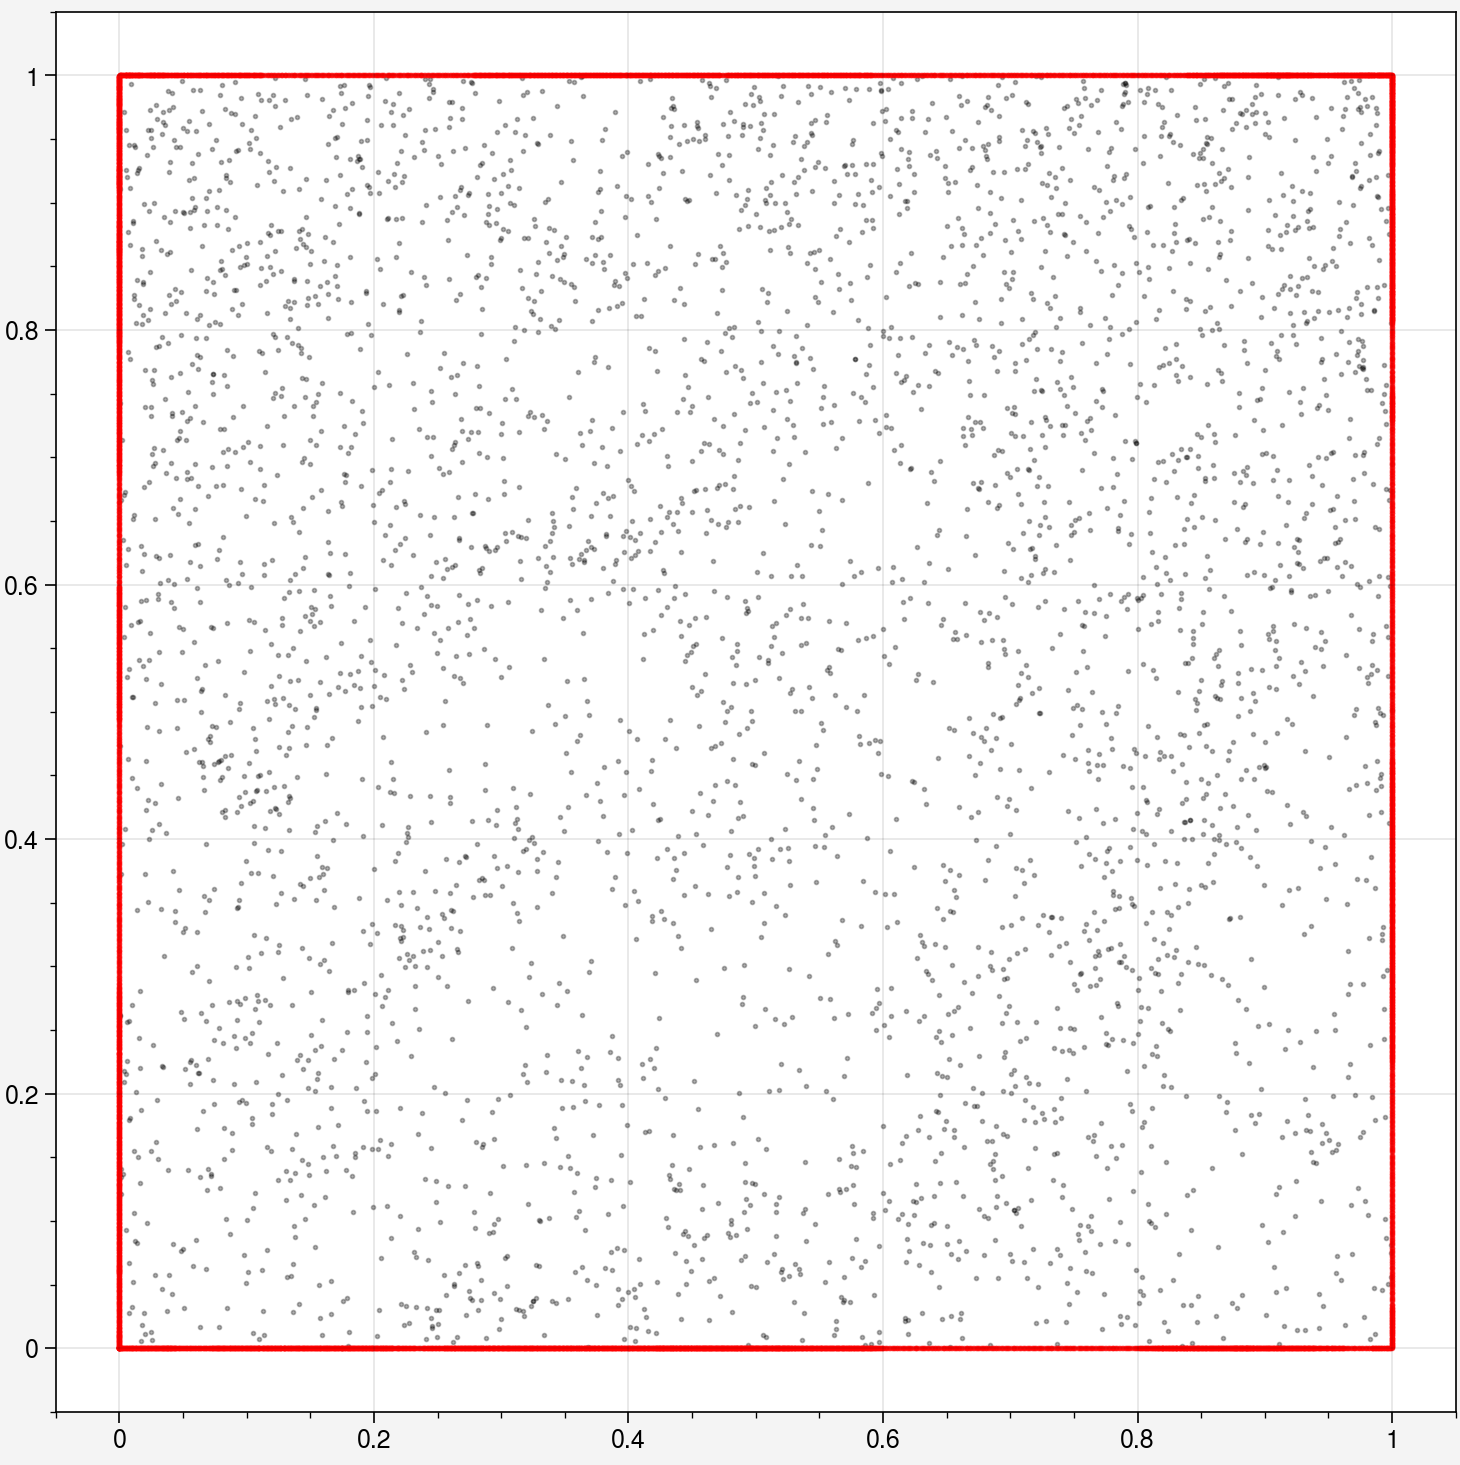

In [9]:
domain.show_coordinates()

Save or Load the model for later use

In [10]:
model2.save_as_pickle("model.pkl")
model2 = df.load_from_pickle("model.pkl")

## 4. Visualization

### 4.1 Visualize area

In [11]:
df.Visualizer.refwidth_default = 4

In [12]:
# Create object for evaluation
area_eval = domain.area_list[0].evaluate(model2)
# Sampling uniform points
area_eval.sampling_area([200, 200])
# Show available data's key
print(area_eval)

Available data keys: ('u', 'v', 'p', 'pde_residual', 'x', 'y', 'u_x', 'u_y', 'v_x', 'v_y', 'p_x', 'p_y', 'continuity_residual', 'x_momentum_residual', 'y_momentum_residual', 'total_loss', 'bc_loss', 'pde_loss')


In [13]:
area_eval['v_mag'] = (area_eval['u']**2 + area_eval['v']**2)**0.5

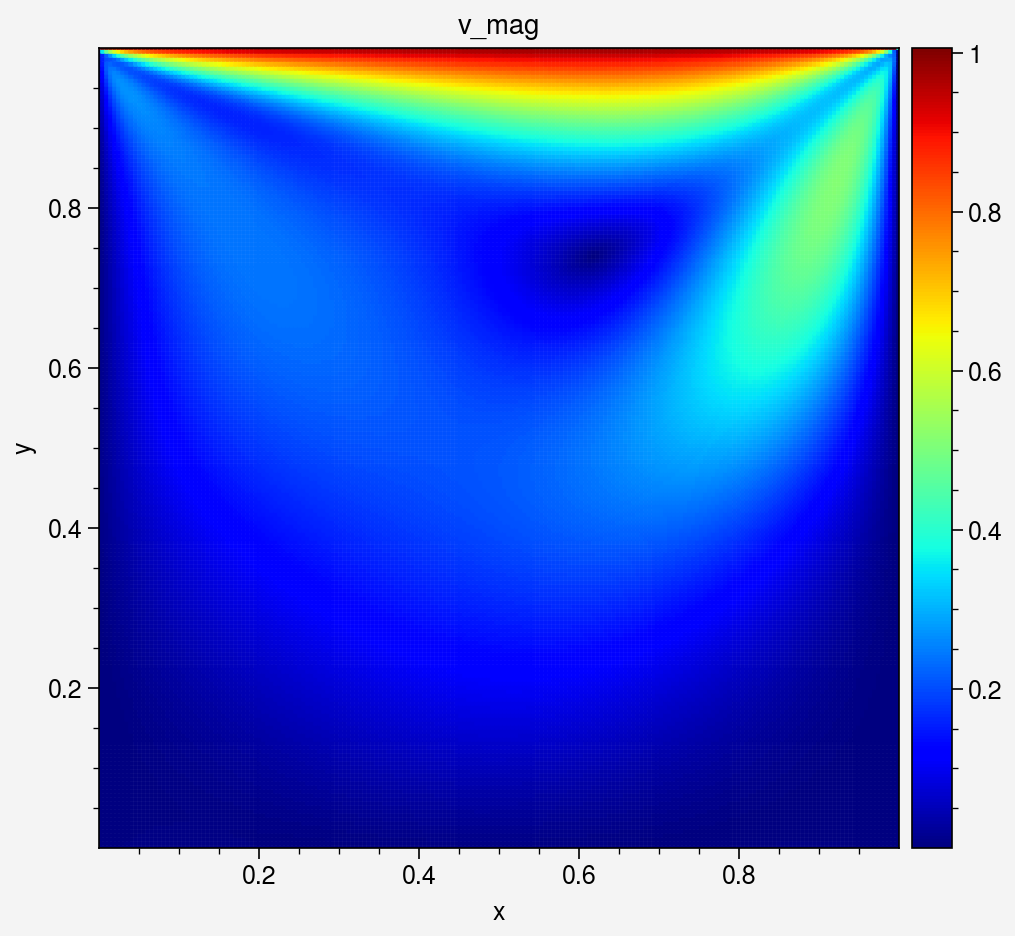

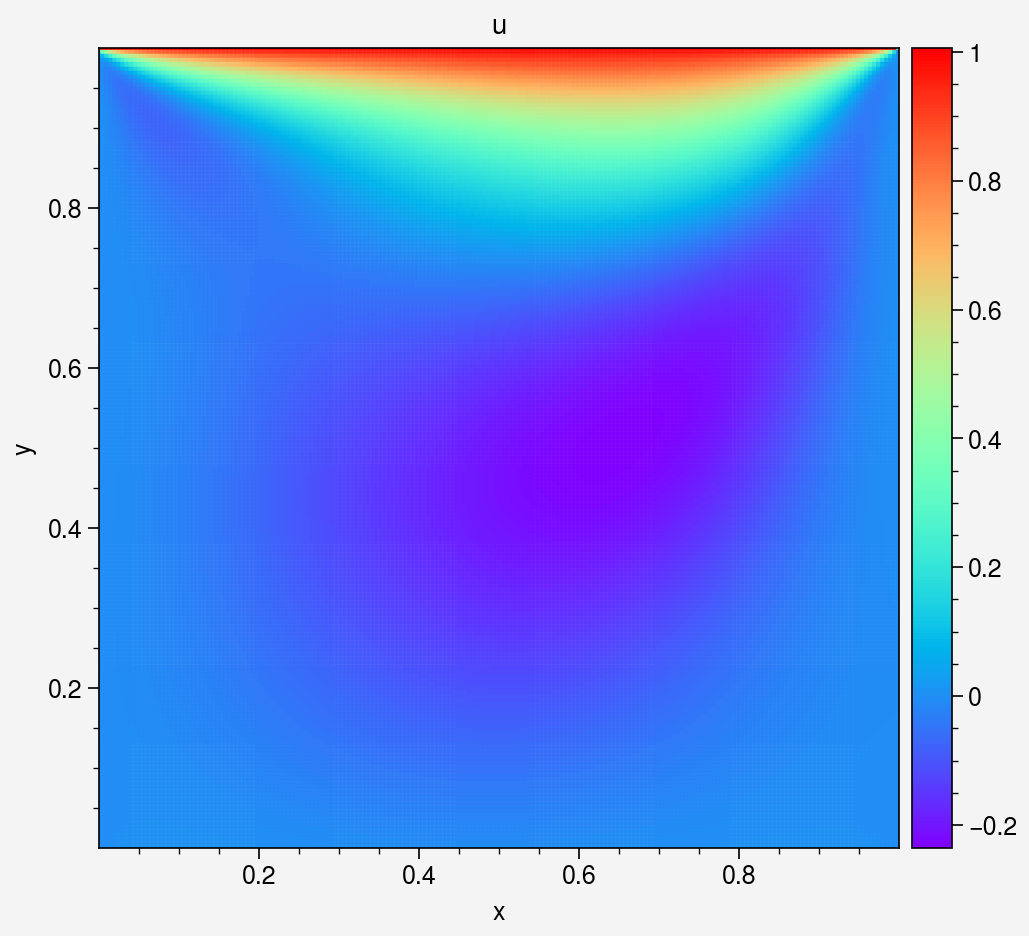

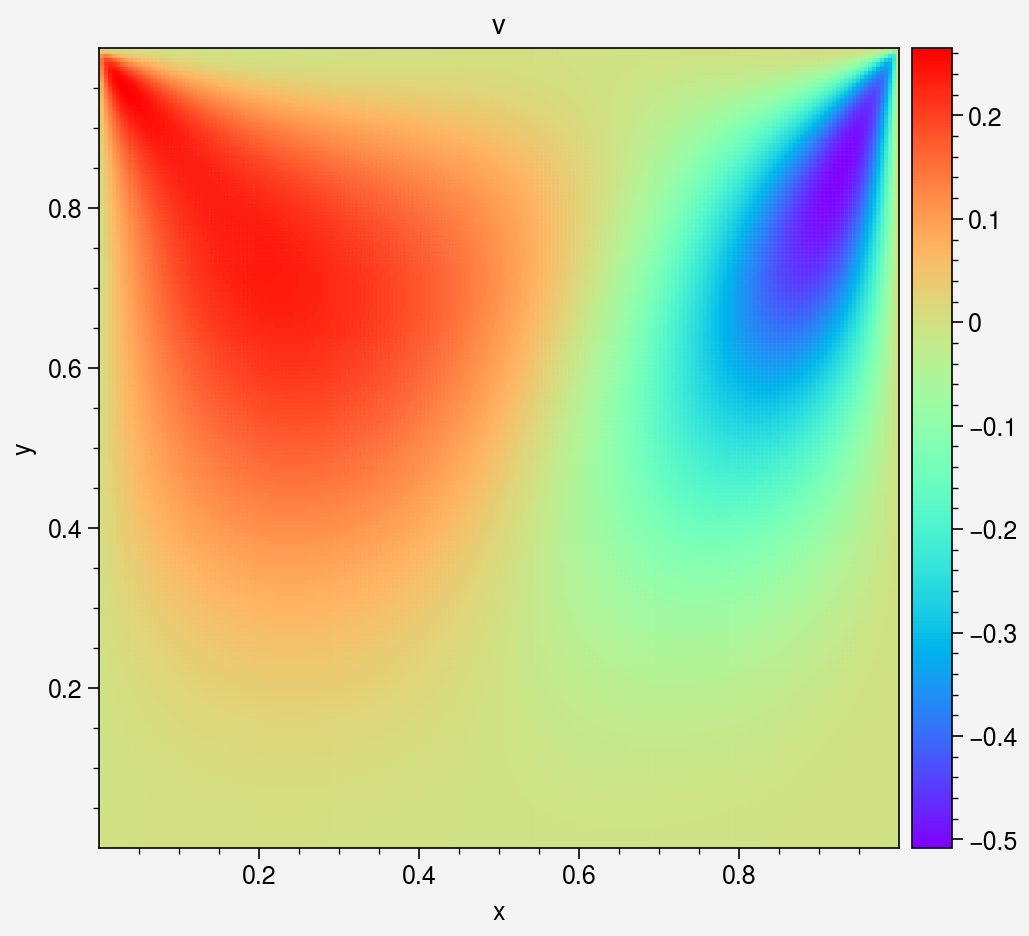

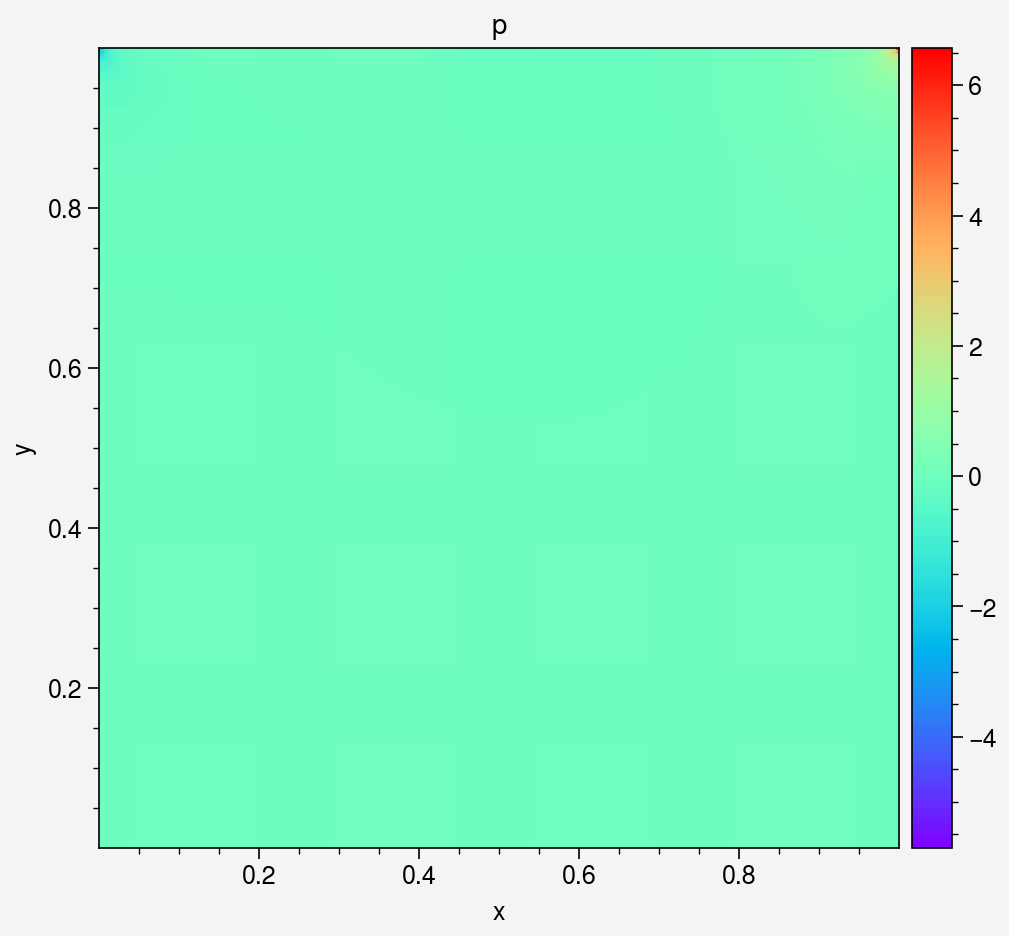

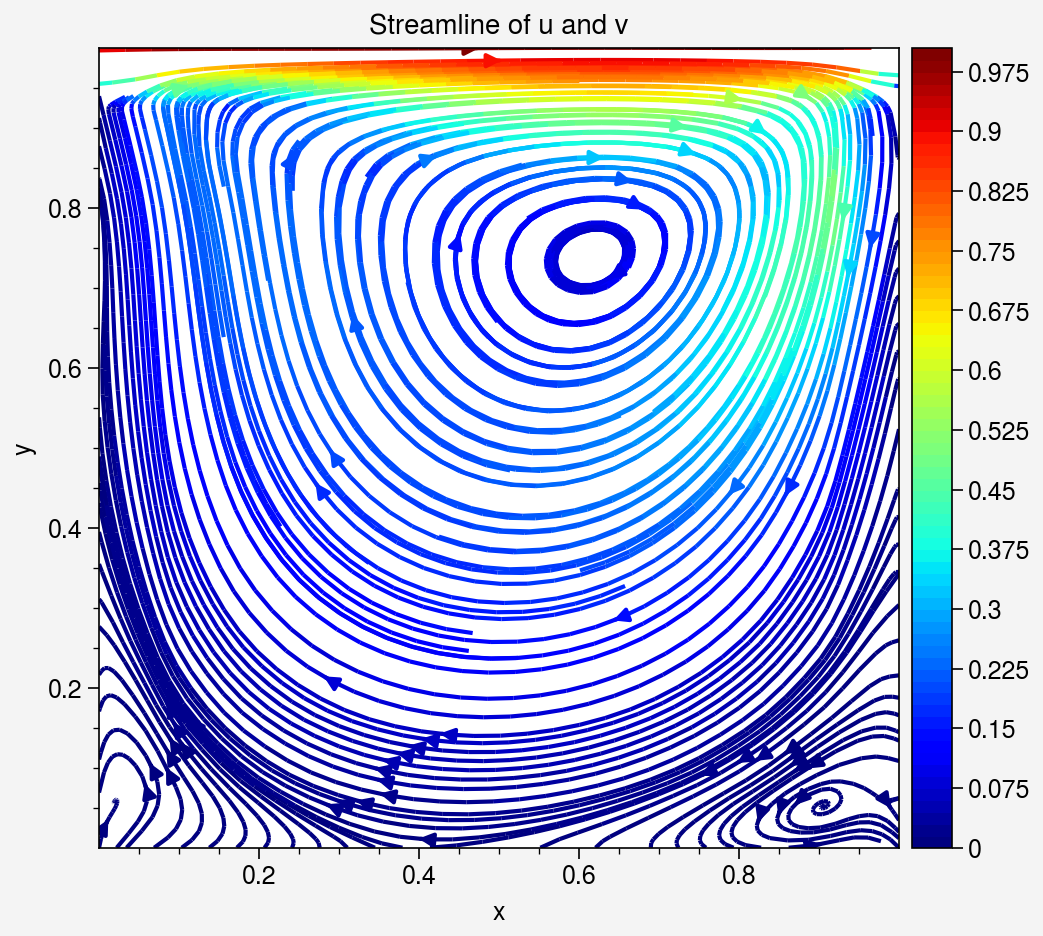

In [19]:
_ = area_eval.plot_color('v_mag', s=1.5, cmap='jet').savefig("colorplot_v_mag.png")
_ = area_eval.plot_color('u', s=1.5, cmap='rainbow')
_ = area_eval.plot_color('v', s=1.5, cmap='rainbow')
_ = area_eval.plot_color('p', s=1.5, cmap='rainbow')
_ = area_eval.plot_streamline('u', 'v', cmap = 'jet')

## 4.2 Visualize Neural Network data

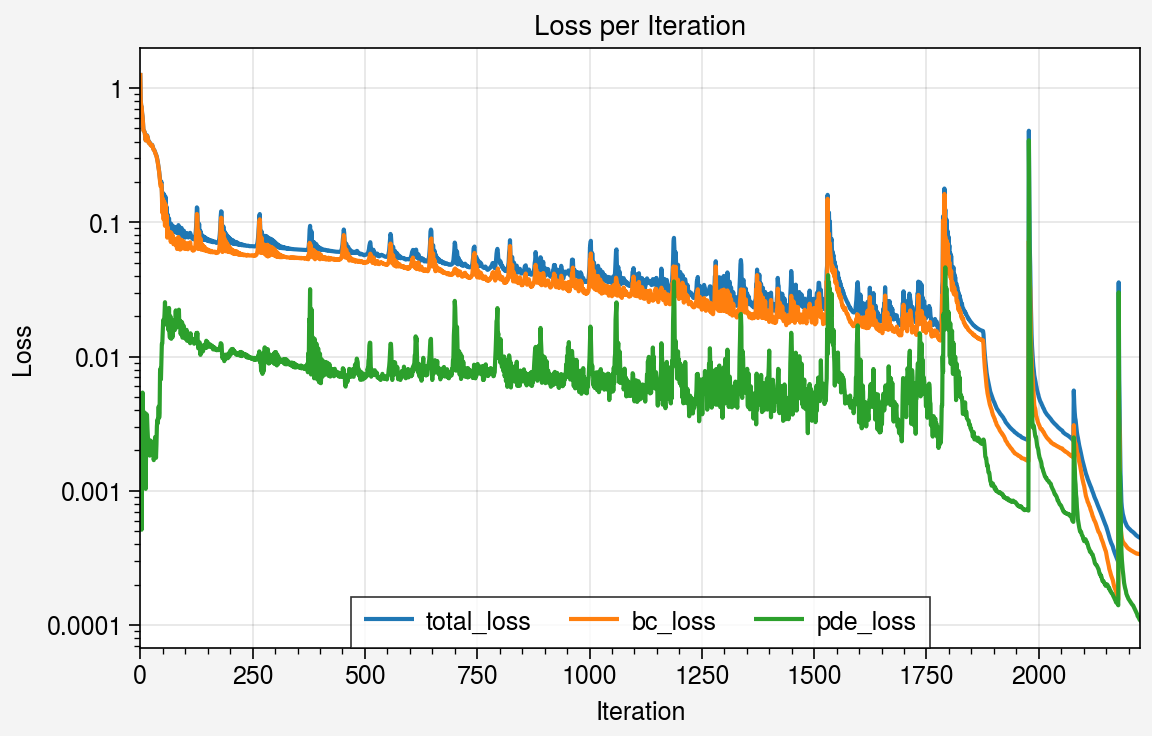

In [15]:
_ = area_eval.plot_loss_curve(log_scale=True)

### 4.4 Export data

In [16]:
# store the x,y,velocity_magnitude data
x_data = area_eval.data_dict['x']
y_data = area_eval.data_dict['y']
u_data = area_eval.data_dict['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity.txt', array)